Import packages!

In [1]:
import numpy as np

Read the splice data

In [2]:
fname = 'splice.data'
with open(fname) as f:
    content = f.readlines()
content = [x.strip().split(',') for x in content]
for l in content:
    for i in range(len(l)):
        l[i] = l[i].strip()
raw_data = np.array(content)

In [3]:
# Given one 'row' of data, constructs an input and output out of it
def getInstance(row):
    one_hot = np.zeros((1, 3))
    label = row[0]
    if label == 'EI':
        one_hot[0][0] = 1
    elif label == 'IE':
        one_hot[0][1] = 1
    else:
        one_hot[0][2] = 1
    orth = np.zeros((len(row[2]), 4))
    for i in range(len(row[2])):
        c = row[2][i]
        if c == 'A':
            orth[i][0] = 1
        elif c == 'C':
            orth[i][1] = 1
        elif c == 'G':
            orth[i][2] = 1
        elif c == 'T':
            orth[i][3] = 1
        elif c == 'D':
            orth[i][0] = 1/3.
            orth[i][2] = 1/3.
            orth[i][3] = 1/3.
        elif c == 'N':
            orth[i][0] = 1/4.
            orth[i][1] = 1/4.
            orth[i][2] = 1/4.
            orth[i][3] = 1/4.
        elif c == 'S':
            orth[i][1] = 1/2.
            orth[i][2] = 1/2.
        elif c == 'R':
            orth[i][0] = 1/2.
            orth[i][2] = 1/2.
    return orth, one_hot

In [421]:
x = []
y = []
for i in range(raw_data.shape[0]):
    xi, yi = getInstance(raw_data[i])
    x.append(xi)
    y.append(yi)
x = np.array(x)
y = np.array(y)

# Shuffle dataset since it's unevenly distributed
shuffle_index = np.random.permutation(len(x))
x = x[shuffle_index]
y = y[shuffle_index]

# Conv1D expects channels first
x = np.swapaxes(x, 1, 2)
print (str(x.shape[0]) + " examples parsed.")

(3190, 4, 60) (3190, 1, 3)


Construct a classification model

In [304]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D, Dropout, MaxPooling1D
from keras.callbacks import TensorBoard
from keras import backend as K

In [305]:
from keras.backend import clear_session
clear_session()
K.set_learning_phase(True)

In [334]:
model = Sequential()
model.add(Conv1D(8, 3, input_shape=(None, 60), padding='same', name='conv1'))
model.add(Activation('relu'))
model.add(MaxPooling1D())
model.add(Conv1D(16, 3, padding='same', name='conv2'))
model.add(Activation('relu'))
model.add(MaxPooling1D())
model.add(Dense(3, name='fc1'))
model.add(Dropout(0.5))
model.add(Activation('softmax'))

In [335]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [336]:
callbacks = []
#callbacks.append(TensorBoard(write_graph=False, histogram_freq=1, write_grads=False, write_images=False))

model.fit(x, y, epochs=30, batch_size=32, validation_split=0.1, shuffle=True, callbacks=callbacks)
K.set_learning_phase(False)

Train on 2871 samples, validate on 319 samples
Epoch 1/30
2871/2871 [==============================] - 4s 1ms/step - loss: 0.9931 - acc: 0.5131 - val_loss: 0.8256 - val_acc: 0.6583
Epoch 2/30
2871/2871 [==============================] - 1s 206us/step - loss: 0.6208 - acc: 0.7844 - val_loss: 0.4016 - val_acc: 0.8871
Epoch 3/30
2871/2871 [==============================] - 1s 176us/step - loss: 0.3112 - acc: 0.9094 - val_loss: 0.2267 - val_acc: 0.9310
Epoch 4/30
2871/2871 [==============================] - 0s 163us/step - loss: 0.1968 - acc: 0.9446 - val_loss: 0.1753 - val_acc: 0.9373
Epoch 5/30
2871/2871 [==============================] - 0s 161us/step - loss: 0.1477 - acc: 0.9606 - val_loss: 0.1473 - val_acc: 0.9530
Epoch 6/30
2871/2871 [==============================] - 0s 150us/step - loss: 0.1193 - acc: 0.9666 - val_loss: 0.1414 - val_acc: 0.9498
Epoch 7/30
2871/2871 [==============================] - 0s 139us/step - loss: 0.0999 - acc: 0.9725 - val_loss: 0.1373 - val_acc: 0.9498
Epo

In [434]:
import matplotlib.pyplot as plt

def visualizeLayer(layer_name, filter_index):
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer_output = layer_dict[layer_name].output
    print (layer_output)
    #loss = K.mean(layer_output[:, :, filter_index])
    loss = K.mean(model.output[:, :, filter_index])
    input_img = model.input
    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    #grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])
    # we start from a gray image with some noise
    input_img_data = np.zeros((1, 4, 60))
    input_img_data[:] = 0.25
    # run gradient ascent for 20 steps
    step = 1
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
        #print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            # break
            pass
    input_img_data[0] /= np.linalg.norm(input_img_data[0], 1, axis=0)
    input_img_data = np.clip(input_img_data, 0, 1)
    plt.imshow(input_img_data[0], cmap='viridis')
    plt.xticks(np.arange(60), np.arange(60)+1)
    plt.yticks(np.arange(4), ('A', 'C', 'G', 'T'))
    plt.show()

Tensor("conv1_4/add:0", shape=(?, ?, 8), dtype=float32)


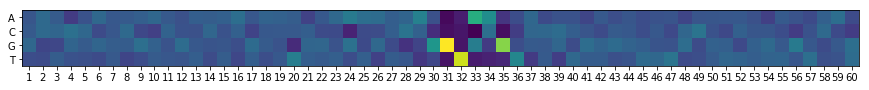

In [435]:
visualizeLayer('conv1', 0)

(?, ?, 3)
Tensor("gradients_64/conv1_4/convolution/ExpandDims_grad/Reshape:0", shape=(?, ?, 60), dtype=float32)
Label is 2


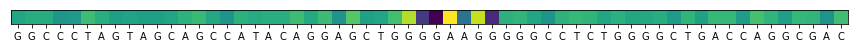

In [404]:
index = 1
print (model.output.shape)
loss = K.mean(model.output[:, :, np.argmax(y[index])])
input_img = model.input
grads = K.gradients(loss, input_img)[0]
print (grads)
iterate = K.function([input_img], [loss, grads])
input_img_data = np.zeros((1, 4, 60))
input_img_data[0,:] = x[index]
loss_value, grads_value = iterate([input_img_data])

print ("Label is " + str(np.argmax(y[index])))
g = grads_value[0] * x[index]
g = np.sum(g, axis=0).reshape(1, 60)
def sequenceFromOneHot(s):
    s = s.T
    l = []
    for i in range(len(s)):
        if s[i][0] == 1.:
            l.append('A')
        elif s[i][1] == 1.:
            l.append('C')
        elif s[i][2] == 1.:
            l.append('G')
        elif s[i][3] == 1.:
            l.append('T')
        elif s[i][0] == 1/3. and s[i][2] == 1/3. and s[i][3] == 1/3.:
            l.append('D')
        elif s[i][0] == 1/4. and s[i][1] == 1/4. and s[i][2] == 1/4. and s[i][3] == 1/4.:
            l.append('N')
        elif s[i][1] == 1/2. and s[i][2] == 1/2.:
            l.append('S')
        elif s[i][0] == 1/2. and s[i][2] == 1/2.:
            l.append('R')
    return l
plt.xticks( np.arange(60), sequenceFromOneHot(x[index]) )
plt.yticks([])
plt.imshow(g, cmap='viridis')
plt.show()

In [383]:
fig_size = plt.rcParams["figure.figsize"]
print (fig_size)
fig_size[0] = 15
fig_size[1] = 10

[12, 8]


In [426]:
# Perturbation:
index = 0
label = y[index]
prediction = model.predict(np.array([x[index]]))
print (label, prediction)
e = np.array(x[index])
target = 2
i = 0

loss = K.mean(model.output[:, :, target])
input_img = model.input
grads = K.gradients(loss, input_img)[0]
iterate = K.function([input_img], [loss, grads])
input_img_data = np.zeros((1, 4, 60))

step = 10.

while True:
    i += 1
    input_img_data[0,:] = e
    loss_value, grads_value = iterate([input_img_data])
    e += grads_value[0] * step
    print(loss_value)
    print (model.predict(np.array([e])))
    if (loss_value > 0.99):
        break
print (sequenceFromOneHot(x[index]))
en = np.argmax(e, axis=0)
new_seq = []
for i in en:
    if i == 0:
        new_seq.append('A')
    elif i == 1:
        new_seq.append('C')
    elif i == 2:
        new_seq.append('G')
    else:
        new_seq.append('T')
print (new_seq)

[[ 0.  1.  0.]] [[[  2.41259013e-08   9.99948621e-01   5.13993073e-05]]]
5.13993e-05
[[[  2.60705182e-08   9.99937773e-01   6.22441148e-05]]]
6.22441e-05
[[[  2.87611090e-08   9.99922633e-01   7.73485372e-05]]]
7.73485e-05
[[[  3.24939897e-08   9.99898672e-01   1.01319609e-04]]]
0.00010132
[[[  3.81263341e-08   9.99855638e-01   1.44300167e-04]]]
0.0001443
[[[  4.78713780e-08   9.99761283e-01   2.38758104e-04]]]
0.000238758
[[[  6.97509677e-08   9.99450743e-01   5.49164950e-04]]]
0.000549165
[[[  1.70917033e-07   9.96487021e-01   3.51292174e-03]]]
0.00351292
[[[  3.04796004e-07   3.13053583e-03   9.96869147e-01]]]
0.996869
[[[  3.26829230e-08   1.05160291e-06   9.99998927e-01]]]
['A', 'A', 'G', 'C', 'C', 'A', 'G', 'A', 'T', 'A', 'T', 'G', 'T', 'C', 'T', 'G', 'T', 'G', 'T', 'T', 'C', 'T', 'C', 'T', 'T', 'T', 'G', 'C', 'A', 'G', 'T', 'A', 'C', 'T', 'G', 'A', 'A', 'G', 'A', 'T', 'A', 'A', 'C', 'A', 'G', 'C', 'C', 'A', 'G', 'G', 'G', 'A', 'G', 'G', 'A', 'C', 'A', 'A', 'G', 'C']
['A', 'A', '